## Курсовой проект по курсу "Интерпретируемый ИИ и майнинг данных"
### Часть 1: Работа с табличными данными
### Этап 3.3: Построение моделей: Нейронная сеть MLPClassifier

**Материалы к проекту (файлы):**<br>
* X_train.csv/y_train.csv - тренировочная выборка<br>
* X_test.csv/y_test.csv - тестовая выборка<br>

**Целевая переменная:**
HeartDisease: output class [1: heart disease, 0: Normal]

**Описание датасета:**
Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of 5CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

**Атрибуты:**
1. Age: age of the patient [years] - **Возраст**
2. Sex: sex of the patient [M: Male, F: Female] - **Пол**
3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic] - **Тип боли в груди**
4. RestingBP: resting blood pressure [mm Hg] - **Артериальное давление в покое**
5. Cholesterol: serum cholesterol [mm/dl] - **Холестерин** 
6. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise] - **Уровень сахара в крови натощак**
7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria] - **ЭКГ в покое**
8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202] - **Максимальная частота сердечных сокращений**
9. ExerciseAngina: exercise-induced angina [Y: Yes, N: No] - **Стенокардия, вызванная физической нагрузкой**
10. Oldpeak: oldpeak = ST [Numeric value measured in depression] - **ST в покое**
11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping] - **ST при пиковой нагрузке**
12. HeartDisease: output class [1: heart disease, 0: Normal] - **Сердечный приступ**

## Шаг 1: Подготовка инструментов

### 1.1 Необходимые модули и функции

In [1]:
import dill
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))

### 1.2 Загрузка пайплайна препроцессинга

In [3]:
with open('../EDA_and_Preprocessing/prep_with_cat.dill', 'rb') as prep_cat_pipeline:
    prep_cat = dill.load(prep_cat_pipeline)

### 1.3 Загрузка данных

In [4]:
TRAIN_DATA_PATH = '../data/X_train.csv'
TRAIN_TARGET_PATH = '../data/y_train.csv'

TEST_DATA_PATH = '../data/X_test.csv'
TEST_TARGET_PATH = '../data/y_test.csv'

In [5]:
train_base = pd.read_csv(TRAIN_DATA_PATH)
train = train_base.copy()
train_target_base = pd.read_csv(TRAIN_TARGET_PATH)
train_target = train_target_base.copy()
display(train.shape, train_target.shape)

(641, 11)

(641, 1)

In [6]:
test_base = pd.read_csv(TEST_DATA_PATH)
test = test_base.copy()
test_target_base = pd.read_csv(TEST_TARGET_PATH)
test_target = test_target_base.copy()
display(test.shape, test_target.shape)

(276, 11)

(276, 1)

## Шаг 2: Построение модели

### 2.1 Baseline

Обучим модель с параметрами по умолчанию на тренировочной выборке.

In [7]:
classifier = Pipeline([
    ('preprocessing', prep_cat),
    ('classifier', MLPClassifier(random_state = 0)),
])

classifier.fit(train, train_target)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('minmax',
                                                                                    MinMaxScaler())]),
                                                                   ['Age',
                                                                    'RestingBP',
                                                                    'Cholesterol',
                                                                    'FastingBS',
                                                                    'MaxHR',
                                                                    'Oldpeak']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('ohe',
  

Проверим качество полученного бейзлайна.

In [8]:
train_pred_proba = classifier.predict_proba(train)
train_pred = classifier.predict(train)
test_pred_proba = classifier.predict_proba(test)
test_pred = classifier.predict(test)
print(f'Train ROC_AUC: {roc_auc_score(train_target, train_pred_proba.T[1])}')
print(f'Train F1 SCORE: {f1_score(train_target, train_pred)}')
print(f'Test ROC_AUC: {roc_auc_score(test_target, test_pred_proba.T[1])}')
print(f'Test F1 SCORE: {f1_score(test_target, test_pred)}')

Train ROC_AUC: 0.9458946042244926
Train F1 SCORE: 0.8966480446927375
Test ROC_AUC: 0.9454274934906212
Test F1 SCORE: 0.8620689655172414


In [9]:
get_classification_report(train_target['HeartDisease'], train_pred, test_target['HeartDisease'], test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       287
           1       0.89      0.91      0.90       354

    accuracy                           0.88       641
   macro avg       0.88      0.88      0.88       641
weighted avg       0.88      0.88      0.88       641

TEST

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       123
           1       0.91      0.82      0.86       153

    accuracy                           0.86       276
   macro avg       0.86      0.86      0.85       276
weighted avg       0.86      0.86      0.86       276



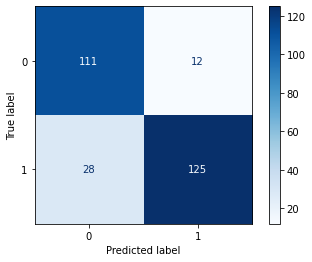

In [10]:
plot_confusion_matrix(classifier, test, test_target['HeartDisease'], cmap=plt.cm.Blues);

### 2.2 Подбор гиперпараметров

Гиперпараметры подбираем с помощью GridSearchCV с кроссвалидацией на 5 фолдов.

In [11]:
%%time
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

frozen_params = {
    'random_state': 0
}
parameters = {
    'solver': ['lbfgs', 'sgd', 'adam'], 
    'max_iter': [500, 1000, 1500, 2000], 
    'alpha': 10.0 ** -np.arange(1, 10), 
    'hidden_layer_sizes':np.arange(5, 15),
    'learning_rate': ['adaptive', 'constant', 'invscaling']
}

clf = GridSearchCV(MLPClassifier(**frozen_params), parameters, n_jobs=-1, verbose=3, scoring='f1' ,cv=cv)

classifier = Pipeline([
    ('preprocessing', prep_cat),
    ('classifier', clf),
])
classifier.fit(train, train_target)

Fitting 5 folds for each of 3240 candidates, totalling 16200 fits


/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Ple

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 3/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.809 total time=   1.5s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.857 total time=   3.5s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.865 total time=   2.0s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.851 total time=   1.8s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.831 total time=   3.2s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.878 total time=   2.9s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.865 total time=   1.4s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1500, solver=lb

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the d

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

[CV 1/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.861 total time=   1.3s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.855 total time=   3.5s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.869 total time=   3.3s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.861 total time=   0.5s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.809 total time=   3.3s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.857 total time=   2.8s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.865 total time=   1.5s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1000, solver=a

[CV 4/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=constant, max_iter=1000, solver=adam;, score=0.845 total time=   2.1s[CV 4/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.820 total time=   1.5s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.878 total time=   3.6s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.865 total time=   1.9s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.863 total time=   2.1s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.855 total time=   3.9s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.869 total time=   2.8s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1000, solver=adam;

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

[CV 2/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.861 total time=   0.5s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.838 total time=   1.5s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.837 total time=   3.7s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.855 total time=   1.9s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.861 total time=   1.2s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.838 total time=   3.3s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.837 total time=   2.7s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1000, solver=

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 2/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.846 total time=   1.7s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.832 total time=   2.7s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.861 total time=   2.6s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.870 total time=   1.4s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.846 total time=   1.6s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.844 total time=   1.7s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.847 total time=   2.8s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=2000, so

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 2/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.871 total time=   2.3s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=constant, max_iter=1500, solver=adam;, score=0.863 total time=   1.3s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=constant, max_iter=1500, solver=adam;, score=0.859 total time=   1.8s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.818 total time=   2.4s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.847 total time=   2.4s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=constant, max_iter=2000, solver=adam;, score=0.872 total time=   1.4s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.867 total time=   1.2s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=500, so

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg


[CV 4/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.832 total time=   2.6s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.861 total time=   2.3s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=constant, max_iter=1500, solver=adam;, score=0.870 total time=   1.4s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.846 total time=   1.6s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.844 total time=   1.7s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.871 total time=   2.2s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=constant, max_iter=2000, solver=adam;, score=0.863 total time=   1.3s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=constant, max_iter=2000, sol

[CV 1/5] END alpha=0.1, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.865 total time=   2.4s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.844 total time=   1.7s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.871 total time=   2.3s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=constant, max_iter=1000, solver=adam;, score=0.863 total time=   1.3s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=constant, max_iter=1000, solver=adam;, score=0.859 total time=   1.8s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.818 total time=   2.4s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.847 total time=   2.4s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=6, learning_rate=constant, max_iter=1500, so

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the d


[CV 1/5] END alpha=0.1, hidden_layer_sizes=7, learning_rate=constant, max_iter=1000, solver=adam;, score=0.849 total time=   1.5s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=7, learning_rate=constant, max_iter=1000, solver=adam;, score=0.857 total time=   1.2s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.825 total time=   1.7s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.846 total time=   1.8s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=adam;, score=0.849 total time=   1.5s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=adam;, score=0.867 total time=   1.3s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.865 total time=   2.4s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, s

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 5/5] END alpha=0.1, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.846 total time=   1.9s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.867 total time=   1.3s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.865 total time=   2.2s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.443 total time=   0.2s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.548 total time=   0.2s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.849 total time=   1.5s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.857 total time=   1.2s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=8, learning_rate=adaptive, max_i

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 1/5] END alpha=0.1, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.849 total time=   1.5s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.857 total time=   1.3s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.825 total time=   1.9s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.459 total time=   0.2s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.487 total time=   0.2s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.538 total time=   0.2s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.872 total time=   1.8s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=8, learning_rate=adaptive, max_ite

[CV 2/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.865 total time=   1.9s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.835 total time=   1.1s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.859 total time=   2.4s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.872 total time=   1.6s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.865 total time=   1.8s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.835 total time=   2.4s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.845 total time=   2.3s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=1000, solver=ada

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec


[CV 4/5] END alpha=0.1, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.875 total time=   1.8s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.786 total time=   1.2s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.865 total time=   2.0s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.865 total time=   1.2s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.869 total time=   1.4s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.794 total time=   2.4s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.865 total time=   2.0s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg


[CV 5/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.886 total time=   2.1s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.880 total time=   1.7s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.789 total time=   4.4s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.863 total time=   2.1s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.865 total time=   1.3s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.869 total time=   1.4s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.786 total time=   1.1s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=constant, max_iter=500, solver

[CV 2/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=constant, max_iter=2000, solver=adam;, score=0.872 total time=   3.1s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.809 total time=   4.0s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.867 total time=   2.1s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.889 total time=   2.0s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.861 total time=   1.3s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.867 total time=   1.1s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=constant, max_iter=500, solver=sgd;, score=0.867 total time=   1.8s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=constant, max_iter=500, solver=s

[CV 5/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=constant, max_iter=1500, solver=adam;, score=0.865 total time=   2.3s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=constant, max_iter=500, solver=adam;, score=0.872 total time=   1.4s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.859 total time=   2.4s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.867 total time=   1.8s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.883 total time=   1.8s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=constant, max_iter=1000, solver=adam;, score=0.869 total time=   1.4s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.809 total time=   3.5s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=9, learning_rate=constant, max_iter=1500, solve

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 4/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.800 total time=   2.3s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.855 total time=   2.3s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=adam;, score=0.872 total time=   3.0s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.843 total time=   3.5s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.865 total time=   2.0s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=constant, max_iter=1500, solver=adam;, score=0.847 total time=   1.8s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=constant, max_iter=1500, solver=adam;, score=0.867 total time=   2.9s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=constant, max_iter=20

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 2/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.839 total time=   2.2s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.847 total time=   2.2s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.865 total time=   2.1s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=constant, max_iter=2000, solver=adam;, score=0.847 total time=   1.8s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=constant, max_iter=2000, solver=adam;, score=0.865 total time=   2.4s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.800 total time=   1.2s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.855 total time=   2.7s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=invscaling, max_ite

[CV 3/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.812 total time=   1.2s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.859 total time=   1.2s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.819 total time=   1.2s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.851 total time=   2.7s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.756 total time=   1.9s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.674 total time=   0.1s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.719 total time=   0.1s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=invscaling, 

[CV 1/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.873 total time=   1.2s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.712 total time=   0.1s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.847 total time=   1.8s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.865 total time=   2.4s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.800 total time=   2.3s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.849 total time=   3.4s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.756 total time=   1.9s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=10, learning_rate=invscaling, 

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 4/5] END alpha=0.1, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.875 total time=   2.2s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.794 total time=   2.9s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.830 total time=   4.9s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.817 total time=   1.1s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.824 total time=   1.2s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.855 total time=   2.1s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.872 total time=   2.7s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_it

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 3/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.845 total time=   2.9s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.819 total time=   2.4s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.847 total time=   2.1s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.893 total time=   2.3s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.853 total time=   2.9s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.797 total time=   3.8s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.859 total time=   2.0s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1500

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the d


[CV 1/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.847 total time=   2.1s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.893 total time=   2.1s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.859 total time=   2.9s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.794 total time=   2.5s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.859 total time=   1.9s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.890 total time=   3.6s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.857 total time=   4.2s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1500, s

[CV 3/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=500, solver=sgd;, score=0.832 total time=   2.1s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.847 total time=   1.1s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.859 total time=   2.0s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.875 total time=   2.7s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.857 total time=   2.9s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.830 total time=   2.3s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.845 total time=   2.3s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1000, sol

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/ana

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 1/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.845 total time=   2.1s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.832 total time=   2.1s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=adam;, score=0.872 total time=   2.2s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.869 total time=   3.8s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.845 total time=   2.1s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.851 total time=   2.0s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=1500, solver=adam;, score=0.863 total time=   2.2s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=2000,

[CV 5/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.639 total time=   0.2s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.857 total time=   3.3s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=500, solver=sgd;, score=0.845 total time=   2.2s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=500, solver=sgd;, score=0.878 total time=   2.2s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=500, solver=adam;, score=0.851 total time=   2.8s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.786 total time=   2.6s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.851 total time=   2.1s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, s

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 2/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=500, solver=adam;, score=0.872 total time=   2.2s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.867 total time=   2.4s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.849 total time=   2.4s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.872 total time=   2.1s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=adam;, score=0.867 total time=   2.2s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=adam;, score=0.857 total time=   3.2s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.795 total time=   3.9s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=1

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 5/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.878 total time=   2.3s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=adam;, score=0.835 total time=   2.9s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.777 total time=   3.9s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.872 total time=   2.0s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=1500, solver=adam;, score=0.867 total time=   2.2s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=1500, solver=adam;, score=0.857 total time=   3.2s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.849 total time=   2.5s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=13, learning_rate=constant, max_iter=20

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 2/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=constant, max_iter=2000, solver=adam;, score=0.867 total time=   5.3s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.819 total time=   1.2s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.857 total time=   2.8s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.828 total time=   2.5s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.655 total time=   0.2s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.677 total time=   0.2s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.639 total time=   0.2s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling, 

[CV 4/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.808 total time=   1.0s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.841 total time=   4.4s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.828 total time=   3.4s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.655 total time=   0.2s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.608 total time=   0.2s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.677 total time=   0.2s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.677 total time=   0.2s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling, 

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 5/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.865 total time=   2.1s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.861 total time=   3.5s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.800 total time=   3.8s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.865 total time=   2.1s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.861 total time=   3.2s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.792 total time=   5.1s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.865 total time=   2.1s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=5, learning_rate=ada

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 1/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.655 total time=   0.2s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.608 total time=   0.2s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.677 total time=   0.2s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.677 total time=   0.2s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.855 total time=   2.0s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.845 total time=   3.4s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.797 total time=   5.0s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=14, learning_rate=invscaling

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 2/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.871 total time=   2.8s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.863 total time=   1.3s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.855 total time=   1.9s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.830 total time=   1.2s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.814 total time=   2.7s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.847 total time=   2.7s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.855 total time=   1.8s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=20

[CV 4/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.873 total time=   1.5s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.867 total time=   2.7s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.836 total time=   2.7s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.861 total time=   2.6s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.855 total time=   2.7s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.808 total time=   1.0s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.845 total time=   2.4s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1500,

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg


[CV 2/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.830 total time=   1.4s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.828 total time=   1.3s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=constant, max_iter=500, solver=sgd;, score=0.861 total time=   2.2s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=constant, max_iter=500, solver=adam;, score=0.855 total time=   1.8s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.830 total time=   1.3s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.808 total time=   1.0s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.871 total time=   2.3s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=constant, max_iter=1000

[CV 1/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.841 total time=   1.6s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.872 total time=   1.7s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.899 total time=   1.2s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.806 total time=   1.1s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=constant, max_iter=500, solver=sgd;, score=0.845 total time=   2.2s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=constant, max_iter=500, solver=sgd;, score=0.844 total time=   2.2s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.887 total time=   2.4s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=6, learning_rate=constant, max_iter=1000, s

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 3/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=constant, max_iter=1000, solver=adam;, score=0.857 total time=   3.7s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.841 total time=   3.5s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=adam;, score=0.857 total time=   3.4s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.849 total time=   1.8s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.859 total time=   1.4s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.878 total time=   1.5s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, solver=adam;, score=0.875 total time=   1.2s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=

[CV 2/5] END alpha=0.01, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.872 total time=   1.6s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=constant, max_iter=1000, solver=adam;, score=0.875 total time=   1.3s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.853 total time=   3.7s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.873 total time=   1.5s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=adam;, score=0.872 total time=   2.1s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.806 total time=   2.0s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.841 total time=   3.4s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=constant, max_iter=

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 3/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.870 total time=   1.5s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, solver=adam;, score=0.872 total time=   2.1s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.846 total time=   1.1s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.814 total time=   1.1s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.875 total time=   1.2s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.806 total time=   2.1s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.841 total time=   2.6s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=invscaling,

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg


[CV 2/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.872 total time=   2.3s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.806 total time=   2.0s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.841 total time=   3.5s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.806 total time=   2.0s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.841 total time=   3.3s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.865 total time=   1.2s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.845 total time=   1.2s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=8, learning_rate=adapt

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 1/5] END alpha=0.01, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.832 total time=   2.3s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.837 total time=   2.2s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.000 total time=   0.7s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.869 total time=   1.8s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.806 total time=   2.8s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.000 total time=   0.7s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.000 total time=   0.7s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=8, learning_rate=invscal

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/ana


[CV 5/5] END alpha=0.01, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.780 total time=   4.6s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.788 total time=   1.2s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.752 total time=   1.1s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.863 total time=   2.1s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.861 total time=   1.1s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.872 total time=   2.2s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.825 total time=   2.4s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=10

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 4/5] END alpha=0.01, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.869 total time=   1.5s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.761 total time=   2.4s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.865 total time=   1.9s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.877 total time=   1.3s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.861 total time=   1.2s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.800 total time=   3.8s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.865 total time=   2.0s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=150

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 5/5] END alpha=0.01, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.872 total time=   2.2s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.819 total time=   4.8s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.886 total time=   2.1s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.872 total time=   2.3s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=9, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.752 total time=   1.1s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=9, learning_rate=constant, max_iter=500, solver=sgd;, score=0.877 total time=   1.7s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=9, learning_rate=constant, max_iter=500, solver=adam;, score=0.861 total time=   1.1s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=9, learning_rate=constant, max_iter=1000,

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optim

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 5/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.783 total time=   1.1s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.847 total time=   2.4s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.892 total time=   2.5s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.857 total time=   3.2s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.783 total time=   4.9s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.867 total time=   2.3s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.857 total time=   2.9s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=constant, max_

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 3/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.809 total time=   2.6s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.867 total time=   2.1s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=adam;, score=0.857 total time=   2.8s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.817 total time=   3.5s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.865 total time=   2.0s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=constant, max_iter=1500, solver=adam;, score=0.847 total time=   1.7s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=constant, max_iter=1500, solver=adam;, score=0.857 total time=   2.8s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=constant, max

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 5/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.783 total time=   1.1s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.843 total time=   2.7s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.809 total time=   2.5s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.658 total time=   0.1s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.865 total time=   3.3s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.817 total time=   1.9s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.783 total time=   1.1s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=10, learning_rat

[CV 5/5] END alpha=0.01, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.855 total time=   3.8s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.892 total time=   2.6s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.843 total time=   4.0s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=constant, max_iter=500, solver=sgd;, score=0.847 total time=   2.1s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=constant, max_iter=500, solver=sgd;, score=0.892 total time=   2.5s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=constant, max_iter=500, solver=adam;, score=0.857 total time=   2.8s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.811 total time=   2.3s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=10, learning_rate=constant, max_ite

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the d

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the d

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Ple

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 5/5] END alpha=0.01, hidden_layer_sizes=11, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.872 total time=   2.5s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=11, learning_rate=constant, max_iter=1000, solver=adam;, score=0.867 total time=   4.0s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=11, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.780 total time=   2.6s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=11, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.792 total time=   3.8s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=11, learning_rate=constant, max_iter=1500, solver=adam;, score=0.884 total time=   3.3s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=11, learning_rate=constant, max_iter=1500, solver=adam;, score=0.855 total time=   3.9s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=11, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.786 total time=   5.0s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=11, learning_rate=constant, m

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-ve

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 5/5] END alpha=0.01, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.794 total time=   1.2s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.841 total time=   4.5s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.786 total time=   3.9s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.841 total time=   4.6s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.786 total time=   5.4s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.841 total time=   4.6s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.855 total time=   2.4s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=12, learning_rate=

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/ana


[CV 5/5] END alpha=0.01, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.794 total time=   1.2s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.871 total time=   3.2s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.867 total time=   2.7s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.800 total time=   1.2s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.822 total time=   1.4s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.845 total time=   2.2s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.845 total time=   2.8s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=12, learning_rate=adaptive,

[CV 5/5] END alpha=0.01, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.841 total time=   5.7s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.831 total time=   2.5s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.778 total time=   2.4s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.867 total time=   2.6s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.780 total time=   2.5s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.794 total time=   1.2s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.871 total time=   3.2s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=11, learning_rat

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 1/5] END alpha=0.01, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.884 total time=   2.7s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.857 total time=   4.6s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.757 total time=   4.4s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.845 total time=   4.0s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.768 total time=   1.4s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.845 total time=   2.5s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.878 total time=   2.5s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=13, learning_rate=adaptive

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 5/5] END alpha=0.01, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.789 total time=   5.3s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.839 total time=   3.3s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.841 total time=   5.7s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=13, learning_rate=constant, max_iter=500, solver=sgd;, score=0.878 total time=   2.3s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=13, learning_rate=constant, max_iter=500, solver=adam;, score=0.843 total time=   3.0s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.779 total time=   2.8s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.872 total time=   2.1s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=13, learning_rate=constant, max_i

[CV 1/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=constant, max_iter=2000, solver=adam;, score=0.849 total time=   2.6s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.845 total time=   2.5s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.832 total time=   2.3s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.871 total time=   3.5s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.859 total time=   4.5s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.811 total time=   5.3s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.878 total time=   2.5s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=13, learning_rate=adaptive, max_i

[CV 5/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.774 total time=   3.9s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.845 total time=   2.4s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.832 total time=   2.4s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.871 total time=   3.5s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=13, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.873 total time=   1.2s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=13, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.768 total time=   1.3s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=13, learning_rate=constant, max_iter=500, solver=sgd;, score=0.845 total time=   2.1s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=13, learning_rate=constant, max_ite

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 3/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.831 total time=   4.1s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.831 total time=   1.2s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=constant, max_iter=500, solver=sgd;, score=0.847 total time=   1.9s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=constant, max_iter=500, solver=sgd;, score=0.887 total time=   1.9s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=constant, max_iter=500, solver=adam;, score=0.845 total time=   3.1s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.765 total time=   1.9s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.871 total time=   1.9s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=constant, max_iter

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the d

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 1/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.655 total time=   0.2s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.608 total time=   0.2s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.677 total time=   0.2s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.884 total time=   2.9s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.843 total time=   2.5s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.608 total time=   0.2s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.677 total time=   0.2s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=invscal

[CV 3/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.820 total time=   2.4s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=constant, max_iter=1500, solver=adam;, score=0.849 total time=   2.5s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=constant, max_iter=1500, solver=adam;, score=0.872 total time=   3.8s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.761 total time=   3.6s
[CV 2/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.871 total time=   1.7s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.887 total time=   2.0s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=constant, max_iter=2000, solver=adam;, score=0.837 total time=   3.4s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=invscaling, ma

[CV 3/5] END alpha=0.001, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.855 total time=   1.8s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=constant, max_iter=2000, solver=adam;, score=0.872 total time=   3.7s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.756 total time=   1.3s
[CV 3/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.677 total time=   0.2s
[CV 1/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.849 total time=   2.6s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.865 total time=   2.9s
[CV 5/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.786 total time=   3.1s
[CV 4/5] END alpha=0.01, hidden_layer_sizes=14, learning_rate=invsc

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 3/5] END alpha=0.001, hidden_layer_sizes=5, learning_rate=constant, max_iter=2000, solver=adam;, score=0.855 total time=   1.7s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.837 total time=   1.4s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.000 total time=   0.2s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.000 total time=   0.2s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.000 total time=   0.2s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.865 total time=   1.9s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.825 total time=   2.5s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=5, learning_rate=invscal

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 4/5] END alpha=0.001, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.851 total time=   1.6s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.817 total time=   1.4s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.871 total time=   3.3s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.863 total time=   1.7s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.847 total time=   3.7s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.814 total time=   1.3s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.871 total time=   2.6s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=adaptive, max_i

[CV 2/5] END alpha=0.001, hidden_layer_sizes=7, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.859 total time=   1.5s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.861 total time=   2.7s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.855 total time=   2.5s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.842 total time=   2.2s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.820 total time=   2.8s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.861 total time=   2.6s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.855 total time=   1.9s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=adaptive, max_i

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 2/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.850 total time=   1.6s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.845 total time=   3.3s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.844 total time=   3.2s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.898 total time=   3.2s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.845 total time=   2.7s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.844 total time=   2.9s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.867 total time=   3.5s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=adaptive, max_iter

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 1/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.863 total time=   1.5s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.863 total time=   3.6s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.000 total time=   0.2s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.000 total time=   0.1s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.000 total time=   0.2s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.000 total time=   0.1s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.000 total time=   0.2s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=6, learning_rate=invs

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 1/5] END alpha=0.001, hidden_layer_sizes=7, learning_rate=constant, max_iter=1000, solver=adam;, score=0.847 total time=   1.6s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=7, learning_rate=constant, max_iter=1000, solver=adam;, score=0.875 total time=   1.1s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.849 total time=   2.4s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.841 total time=   1.7s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.878 total time=   1.7s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=adam;, score=0.875 total time=   1.1s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.849 total time=   2.6s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=7, learning_rate=constant, max

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 5/5] END alpha=0.001, hidden_layer_sizes=7, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.800 total time=   2.5s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=7, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.873 total time=   1.6s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=7, learning_rate=constant, max_iter=1000, solver=adam;, score=0.857 total time=   3.1s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.800 total time=   2.5s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.870 total time=   1.7s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=adam;, score=0.872 total time=   2.3s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.779 total time=   1.2s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=7, learning_rate=constant, ma

[CV 2/5] END alpha=0.001, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.872 total time=   1.7s[CV 3/5] END alpha=0.001, hidden_layer_sizes=7, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.870 total time=   1.7s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=7, learning_rate=constant, max_iter=1000, solver=adam;, score=0.872 total time=   2.2s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.779 total time=   1.0s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.789 total time=   2.2s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.859 total time=   1.4s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=adam;, score=0.847 total time=   1.7s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=7, learning_rate=constant, max_

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Ple

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 2/5] END alpha=0.001, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.899 total time=   3.6s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.837 total time=   2.5s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.872 total time=   1.8s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=8, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.846 total time=   1.2s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=8, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.877 total time=   1.3s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=8, learning_rate=constant, max_iter=500, solver=sgd;, score=0.831 total time=   2.3s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=8, learning_rate=constant, max_iter=500, solver=sgd;, score=0.851 total time=   2.4s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=8, learning_rate=constant, max_ite

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 1/5] END alpha=0.001, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.846 total time=   1.3s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.851 total time=   2.6s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.000 total time=   0.7s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.869 total time=   1.8s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.899 total time=   3.5s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.028 total time=   0.8s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.855 total time=   1.7s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=8, learning_rat

[CV 3/5] END alpha=0.001, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.794 total time=   2.8s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.028 total time=   0.9s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.855 total time=   1.9s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.865 total time=   2.5s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.865 total time=   2.0s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.886 total time=   2.2s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.797 total time=   2.4s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=9, learning_rate=adaptive, 

[CV 5/5] END alpha=0.001, hidden_layer_sizes=10, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.847 total time=   1.1s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.000 total time=   0.8s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.855 total time=   1.6s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.865 total time=   2.4s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.800 total time=   2.5s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.855 total time=   2.0s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.817 total time=   2.3s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=8, learning_rate=inv

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 4/5] END alpha=0.001, hidden_layer_sizes=9, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.877 total time=   1.8s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=9, learning_rate=constant, max_iter=2000, solver=adam;, score=0.869 total time=   1.5s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.800 total time=   1.2s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.000 total time=   0.7s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.000 total time=   0.6s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.869 total time=   1.5s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.748 total time=   2.4s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=9, learning_rate=invscali

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 3/5] END alpha=0.001, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.855 total time=   2.4s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.865 total time=   2.7s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.794 total time=   2.3s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.803 total time=   2.3s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.867 total time=   2.4s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.843 total time=   3.4s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.794 total time=   3.5s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=10, learning_rate=adapti

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 4/5] END alpha=0.001, hidden_layer_sizes=10, learning_rate=constant, max_iter=500, solver=sgd;, score=0.867 total time=   2.1s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=10, learning_rate=constant, max_iter=500, solver=adam;, score=0.857 total time=   2.7s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.845 total time=   2.1s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.803 total time=   2.5s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.892 total time=   2.6s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=adam;, score=0.843 total time=   4.3s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=10, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.794 total time=   2.7s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=10, learning_rate=consta

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 2/5] END alpha=0.001, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.865 total time=   2.4s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.892 total time=   2.6s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.843 total time=   4.4s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.794 total time=   2.8s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.865 total time=   2.4s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.892 total time=   2.6s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.843 total time=   4.0s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=10, learning_rate=constant

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/ana

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 3/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.839 total time=   2.7s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.886 total time=   2.7s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.871 total time=   3.4s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.855 total time=   4.5s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.855 total time=   2.6s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.871 total time=   3.3s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.855 total time=   4.7s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=adapti

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the d

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optim

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 1/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=constant, max_iter=1500, solver=adam;, score=0.871 total time=   3.6s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.818 total time=   1.9s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.831 total time=   2.9s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.886 total time=   2.1s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=constant, max_iter=2000, solver=adam;, score=0.871 total time=   3.4s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=constant, max_iter=2000, solver=adam;, score=0.855 total time=   4.4s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.875 total time=   2.2s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=inv

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 3/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.831 total time=   3.1s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.855 total time=   2.3s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=constant, max_iter=1500, solver=adam;, score=0.871 total time=   3.4s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=constant, max_iter=1500, solver=adam;, score=0.855 total time=   4.4s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.849 total time=   2.4s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.883 total time=   2.3s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=constant, max_iter=2000, solver=adam;, score=0.847 total time=   4.4s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=invscal

[CV 2/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.872 total time=   2.9s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=constant, max_iter=1500, solver=adam;, score=0.847 total time=   4.5s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.754 total time=   4.0s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.872 total time=   2.5s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=constant, max_iter=2000, solver=adam;, score=0.875 total time=   2.2s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.803 total time=   1.2s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.789 total time=   1.2s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=11, learning_rate=inv

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/an

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 3/5] END alpha=0.001, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.859 total time=   4.9s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=12, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.774 total time=   1.2s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=12, learning_rate=constant, max_iter=500, solver=sgd;, score=0.847 total time=   1.9s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=12, learning_rate=constant, max_iter=500, solver=sgd;, score=0.893 total time=   2.0s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=12, learning_rate=constant, max_iter=500, solver=adam;, score=0.853 total time=   2.8s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=12, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.803 total time=   2.5s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=12, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.859 total time=   1.9s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=12, learning_rate=constant, 

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 1/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.851 total time=   2.6s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.845 total time=   2.5s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.832 total time=   2.4s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.871 total time=   4.3s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.783 total time=   2.1s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.828 total time=   2.9s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.832 total time=   2.3s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=adapt

[CV 5/5] END alpha=0.001, hidden_layer_sizes=14, learning_rate=constant, max_iter=500, solver=adam;, score=0.865 total time=   2.9s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.811 total time=   1.3s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.851 total time=   2.5s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.820 total time=   2.9s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.783 total time=   2.1s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.819 total time=   2.7s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.878 total time=   2.6s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=adaptive,

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 3/5] END alpha=0.001, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.797 total time=   4.9s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.853 total time=   2.9s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.857 total time=   1.3s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.771 total time=   1.4s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.872 total time=   2.4s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.847 total time=   2.9s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.849 total time=   3.0s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=adap

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/ana

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/ana

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 3/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.775 total time=   2.7s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.872 total time=   2.1s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.878 total time=   2.3s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=constant, max_iter=2000, solver=adam;, score=0.841 total time=   3.1s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.794 total time=   1.4s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.822 total time=   1.9s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.509 total time=   0.1s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=13, learning_rate=in

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 5/5] END alpha=0.001, hidden_layer_sizes=14, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.786 total time=   2.6s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=14, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.867 total time=   2.0s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=14, learning_rate=constant, max_iter=1000, solver=adam;, score=0.831 total time=   4.8s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=14, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.776 total time=   3.8s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=14, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.871 total time=   1.8s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=14, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.887 total time=   1.9s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=14, learning_rate=constant, max_iter=1500, solver=adam;, score=0.837 total time=   3.4s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=14, learning_rate=consta

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 3/5] END alpha=0.001, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.782 total time=   4.7s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.871 total time=   2.2s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.882 total time=   2.2s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.837 total time=   3.4s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=14, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.768 total time=   1.3s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=14, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.817 total time=   1.2s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=14, learning_rate=constant, max_iter=500, solver=sgd;, score=0.853 total time=   1.7s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=14, learning_rate=constant

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 1/5] END alpha=0.001, hidden_layer_sizes=14, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.847 total time=   2.0s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=14, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.887 total time=   2.2s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=14, learning_rate=constant, max_iter=1000, solver=adam;, score=0.837 total time=   3.6s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=14, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.845 total time=   3.9s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=14, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.847 total time=   1.9s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=14, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.867 total time=   1.8s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=14, learning_rate=constant, max_iter=1500, solver=adam;, score=0.831 total time=   4.5s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=14, learning_rate=constant

[CV 2/5] END alpha=0.0001, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.000 total time=   0.2s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.878 total time=   2.5s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.865 total time=   1.4s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.841 total time=   1.4s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.855 total time=   2.6s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.869 total time=   2.6s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.863 total time=   1.6s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=5, learning_rate=adaptiv

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec


[CV 2/5] END alpha=0.0001, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.837 total time=   0.8s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.831 total time=   1.2s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.855 total time=   1.4s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.837 total time=   0.7s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.831 total time=   2.2s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.855 total time=   1.4s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.837 total time=   0.8s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=5, lea

[CV 5/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.832 total time=   2.1s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=5, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.878 total time=   2.3s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=5, learning_rate=constant, max_iter=2000, solver=adam;, score=0.865 total time=   1.6s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.833 total time=   1.2s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.000 total time=   0.2s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.000 total time=   0.2s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.000 total time=   0.2s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=5, learning_rate=invs

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec


[CV 4/5] END alpha=0.0001, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.000 total time=   0.2s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.865 total time=   1.5s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.863 total time=   1.5s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.808 total time=   2.0s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.855 total time=   1.4s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.800 total time=   1.4s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.865 total time=   1.5s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=5, lear

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 4/5] END alpha=0.0001, hidden_layer_sizes=6, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.805 total time=   1.0s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=6, learning_rate=constant, max_iter=500, solver=sgd;, score=0.845 total time=   2.1s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=6, learning_rate=constant, max_iter=500, solver=sgd;, score=0.844 total time=   2.3s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=6, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.892 total time=   0.5s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=6, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.867 total time=   0.7s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=6, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.805 total time=   0.9s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=6, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.845 total time=   2.2s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=6, learning_rate=constan

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 1/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.847 total time=   1.8s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.859 total time=   2.0s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.821 total time=   2.0s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.859 total time=   1.7s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.873 total time=   1.7s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.831 total time=   2.9s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.819 total time=   1.0s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=adapt

[CV 4/5] END alpha=0.0001, hidden_layer_sizes=8, learning_rate=constant, max_iter=500, solver=adam;, score=0.869 total time=   1.8s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.873 total time=   1.8s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.837 total time=   2.7s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.846 total time=   1.6s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.841 total time=   1.9s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.878 total time=   1.9s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.851 total time=   2.5s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=adaptive, m

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 4/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=constant, max_iter=500, solver=sgd;, score=0.873 total time=   1.6s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=constant, max_iter=500, solver=adam;, score=0.837 total time=   2.7s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.846 total time=   1.5s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.832 total time=   2.1s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=constant, max_iter=1000, solver=adam;, score=0.847 total time=   1.8s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=constant, max_iter=1000, solver=adam;, score=0.859 total time=   2.0s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.846 total time=   1.5s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=const

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 4/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.873 total time=   1.5s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, solver=adam;, score=0.831 total time=   3.0s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.819 total time=   1.0s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.443 total time=   0.2s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.548 total time=   0.2s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.872 total time=   2.7s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.821 total time=   2.1s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=7, learning_rate=

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 4/5] END alpha=0.0001, hidden_layer_sizes=8, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.806 total time=   1.0s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=8, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.808 total time=   2.3s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=8, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.869 total time=   2.3s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=8, learning_rate=constant, max_iter=1000, solver=adam;, score=0.869 total time=   1.8s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=8, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.806 total time=   0.9s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=8, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.808 total time=   3.5s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=8, learning_rate=constant, max_iter=1500, solver=adam;, score=0.872 total time=   1.8s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=8, learning_rate=co

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg


[CV 1/5] END alpha=0.0001, hidden_layer_sizes=8, learning_rate=constant, max_iter=1000, solver=adam;, score=0.855 total time=   1.5s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=8, learning_rate=constant, max_iter=1000, solver=adam;, score=0.855 total time=   1.9s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=8, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.777 total time=   2.1s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=8, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.837 total time=   2.0s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=8, learning_rate=constant, max_iter=1500, solver=adam;, score=0.855 total time=   1.6s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=8, learning_rate=constant, max_iter=1500, solver=adam;, score=0.855 total time=   2.0s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=8, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.877 total time=   2.0s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=8, learning_rate=cons

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 1/5] END alpha=0.0001, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.855 total time=   1.7s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.865 total time=   2.8s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.000 total time=   0.8s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.000 total time=   0.7s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.872 total time=   1.8s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.833 total time=   1.2s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.806 total time=   0.9s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=8, learnin

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optim

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to 


[CV 2/5] END alpha=0.0001, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.812 total time=   2.4s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.867 total time=   2.1s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.883 total time=   2.0s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.863 total time=   1.5s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.786 total time=   2.5s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.865 total time=   2.0s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.886 total time=   2.1s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=9, learning_rate=adaptiv

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 1/5] END alpha=0.0001, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.877 total time=   1.4s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.863 total time=   1.4s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.786 total time=   2.4s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.000 total time=   0.7s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.000 total time=   0.8s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.872 total time=   2.0s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.812 total time=   3.3s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=9, learn

[CV 1/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.871 total time=   3.6s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.816 total time=   3.6s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.000 total time=   0.9s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.877 total time=   1.6s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.872 total time=   2.5s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.842 total time=   0.7s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.814 total time=   2.8s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=9, learn

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the d

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 1/5] END alpha=0.0001, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.847 total time=   2.5s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.892 total time=   2.5s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.851 total time=   2.8s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.826 total time=   1.9s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.865 total time=   2.4s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.847 total time=   4.4s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.825 total time=   4.0s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=10, learning_rate=a

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 3/5] END alpha=0.0001, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=adam;, score=0.851 total time=   3.5s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=10, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.825 total time=   3.7s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=10, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.847 total time=   2.2s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=10, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.867 total time=   2.1s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=10, learning_rate=constant, max_iter=1500, solver=adam;, score=0.851 total time=   3.5s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=10, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.786 total time=   4.0s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=10, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.865 total time=   2.1s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=10, learning_rat

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/ana

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 5/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.849 total time=   4.6s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.855 total time=   2.6s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.878 total time=   3.3s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.836 total time=   1.8s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.721 total time=   3.2s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.883 total time=   2.5s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.817 total time=   3.4s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=11, learning_ra

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 1/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.849 total time=   2.7s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.872 total time=   2.9s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.883 total time=   2.2s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.803 total time=   1.9s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.771 total time=   1.7s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.855 total time=   2.4s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.878 total time=   3.3s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rat

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 1/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.849 total time=   2.4s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.872 total time=   2.5s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rate=constant, max_iter=1000, solver=adam;, score=0.883 total time=   2.3s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.803 total time=   1.9s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.771 total time=   1.8s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.886 total time=   2.1s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rate=constant, max_iter=1500, solver=adam;, score=0.871 total time=   3.4s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rat

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/ana


[CV 4/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.719 total time=   2.6s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.883 total time=   2.2s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.849 total time=   4.4s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.817 total time=   3.4s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.800 total time=   2.9s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.719 total time=   0.1s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.827 total time=   0.1s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=1

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/ana

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 4/5] END alpha=0.0001, hidden_layer_sizes=12, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.845 total time=   1.9s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=12, learning_rate=constant, max_iter=1500, solver=adam;, score=0.829 total time=   3.6s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=12, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.797 total time=   3.5s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=12, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.775 total time=   1.9s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=12, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.855 total time=   1.9s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=12, learning_rate=constant, max_iter=2000, solver=adam;, score=0.859 total time=   7.1s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.837 total time=   3.0s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=12, learning_r

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

[CV 5/5] END alpha=0.0001, hidden_layer_sizes=12, learning_rate=constant, max_iter=1500, solver=adam;, score=0.844 total time=   5.2s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=12, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.779 total time=   2.2s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=12, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.859 total time=   1.8s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=12, learning_rate=constant, max_iter=2000, solver=adam;, score=0.884 total time=   2.7s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=12, learning_rate=constant, max_iter=2000, solver=adam;, score=0.844 total time=   5.2s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.859 total time=   3.1s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.779 total time=   2.3s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=12, learning

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec


[CV 2/5] END alpha=0.0001, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.797 total time=   3.9s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.479 total time=   0.2s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.509 total time=   0.2s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.491 total time=   0.2s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.859 total time=   7.3s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.779 total time=   2.1s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.859 total time=   7.6s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=13

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 1/5] END alpha=0.0001, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.845 total time=   2.6s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.878 total time=   2.7s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.857 total time=   2.9s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.786 total time=   1.7s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.872 total time=   2.4s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.833 total time=   3.4s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.855 total time=   5.8s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=13, learning_rate=ad

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 1/5] END alpha=0.0001, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.482 total time=   0.1s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.515 total time=   0.1s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.509 total time=   0.1s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.491 total time=   0.1s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.867 total time=   5.2s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.821 total time=   5.3s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.867 total time=   5.6s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=14, 

[CV 1/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.855 total time=   2.6s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.851 total time=   2.5s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.755 total time=   2.2s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.867 total time=   2.0s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.831 total time=   4.1s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.746 total time=   2.0s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.847 total time=   2.2s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=14, learning_rate=

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 1/5] END alpha=0.0001, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.841 total time=   3.4s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.867 total time=   5.4s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.867 total time=   2.1s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.831 total time=   4.3s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.800 total time=   1.3s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.791 total time=   1.3s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.871 total time=   2.1s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=14, learning_ra

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 2/5] END alpha=0.0001, hidden_layer_sizes=14, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.800 total time=   1.1s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=14, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.755 total time=   2.2s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=14, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.867 total time=   1.7s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=14, learning_rate=constant, max_iter=1000, solver=adam;, score=0.831 total time=   4.1s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=14, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.746 total time=   2.1s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=14, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.847 total time=   1.9s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=14, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.887 total time=   2.0s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=14, learning_ra

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 5/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.869 total time=   2.7s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.863 total time=   1.5s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=constant, max_iter=500, solver=sgd;, score=0.855 total time=   2.4s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=constant, max_iter=500, solver=sgd;, score=0.869 total time=   2.3s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.850 total time=   0.5s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.797 total time=   2.3s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.857 total time=   2.2s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=constant, max_ite

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 3/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.797 total time=   1.0s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=constant, max_iter=500, solver=sgd;, score=0.857 total time=   2.1s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=constant, max_iter=500, solver=adam;, score=0.865 total time=   1.4s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=constant, max_iter=500, solver=adam;, score=0.851 total time=   1.3s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.809 total time=   2.4s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.837 total time=   2.2s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=constant, max_iter=1000, solver=adam;, score=0.855 total time=   1.5s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=constant, max_ite

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 4/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=constant, max_iter=1500, solver=adam;, score=0.851 total time=   1.3s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.797 total time=   3.1s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.878 total time=   2.6s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=constant, max_iter=2000, solver=adam;, score=0.865 total time=   1.4s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.855 total time=   1.1s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.857 total time=   1.0s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.851 total time=   1.3s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=invscali

[CV 3/5] END alpha=1e-05, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.806 total time=   1.1s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.865 total time=   1.5s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.863 total time=   1.5s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.865 total time=   1.5s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.851 total time=   1.2s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.797 total time=   2.6s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.865 total time=   1.4s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=5, learning_rate=in

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/ana

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 2/5] END alpha=1e-05, hidden_layer_sizes=6, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.871 total time=   2.3s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=6, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.844 total time=   2.6s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.886 total time=   0.4s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.857 total time=   0.9s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.791 total time=   1.1s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.000 total time=   0.2s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.000 total time=   0.1s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=6, learning_rate=invscalin

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 3/5] END alpha=1e-05, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.791 total time=   1.0s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.786 total time=   2.4s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.886 total time=   0.4s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.857 total time=   0.8s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.829 total time=   1.2s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.000 total time=   0.1s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.000 total time=   0.1s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=6, learning_r

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 2/5] END alpha=1e-05, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.861 total time=   3.4s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.840 total time=   1.2s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.822 total time=   2.7s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.870 total time=   1.8s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.861 total time=   4.4s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=7, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.838 total time=   1.5s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=7, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.822 total time=   1.4s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=7, learning_rate=constant, ma

[CV 3/5] END alpha=1e-05, hidden_layer_sizes=8, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.794 total time=   3.7s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.841 total time=   1.9s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.855 total time=   2.7s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.859 total time=   2.0s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.822 total time=   2.4s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.873 total time=   1.8s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.863 total time=   2.4s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=7, learning_rate=adaptive, max_ite

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 1/5] END alpha=1e-05, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.849 total time=   3.9s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.840 total time=   1.2s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.822 total time=   2.8s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.863 total time=   2.1s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.859 total time=   2.0s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.839 total time=   1.1s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.837 total time=   2.5s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=8, learning_rate=ada

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 1/5] END alpha=1e-05, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.855 total time=   1.5s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.869 total time=   1.8s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.839 total time=   3.6s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.859 total time=   2.4s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.872 total time=   1.8s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.872 total time=   2.3s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.819 total time=   3.8s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=8, learning_rate=adaptive, ma

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optim


[CV 5/5] END alpha=1e-05, hidden_layer_sizes=8, learning_rate=constant, max_iter=1000, solver=adam;, score=0.872 total time=   2.3s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=8, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.819 total time=   3.6s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=8, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.869 total time=   2.2s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=8, learning_rate=constant, max_iter=1500, solver=adam;, score=0.855 total time=   2.0s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=8, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.855 total time=   4.6s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=8, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.859 total time=   2.2s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=8, learning_rate=constant, max_iter=2000, solver=adam;, score=0.855 total time=   1.5s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=8, learning_rate=constant, max

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec


[CV 3/5] END alpha=1e-05, hidden_layer_sizes=8, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.837 total time=   2.0s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=8, learning_rate=constant, max_iter=1500, solver=adam;, score=0.855 total time=   1.5s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=8, learning_rate=constant, max_iter=1500, solver=adam;, score=0.869 total time=   1.9s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=8, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.833 total time=   4.9s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=8, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.837 total time=   2.0s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=8, learning_rate=constant, max_iter=2000, solver=adam;, score=0.872 total time=   1.8s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.846 total time=   1.2s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=8, learning_rate=invscaling, 

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Ple

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 3/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.861 total time=   1.2s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.834 total time=   2.7s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.867 total time=   2.1s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.886 total time=   2.3s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.872 total time=   2.3s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=constant, max_iter=500, solver=sgd;, score=0.867 total time=   1.9s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=constant, max_iter=500, solver=sgd;, score=0.886 total time=   2.1s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=constant, max_iter

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 3/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=constant, max_iter=1500, solver=adam;, score=0.861 total time=   1.2s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.834 total time=   2.7s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.867 total time=   1.9s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.886 total time=   1.8s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=constant, max_iter=2000, solver=adam;, score=0.863 total time=   1.6s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.788 total time=   1.4s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.000 total time=   0.8s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=invscaling, 

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the d

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/ana


[CV 4/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.000 total time=   0.7s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.861 total time=   1.2s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.834 total time=   2.7s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.000 total time=   0.7s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.000 total time=   0.7s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.000 total time=   0.7s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.872 total time=   1.9s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=10, learning_rate=a

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 5/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.872 total time=   2.4s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.843 total time=   2.2s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.000 total time=   0.7s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.863 total time=   1.4s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.824 total time=   2.0s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.814 total time=   2.3s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.861 total time=   1.1s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=9, learning_ra

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 4/5] END alpha=1e-05, hidden_layer_sizes=10, learning_rate=constant, max_iter=2000, solver=adam;, score=0.851 total time=   4.0s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.820 total time=   1.2s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.841 total time=   2.7s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.865 total time=   2.8s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.712 total time=   0.1s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.849 total time=   2.9s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.865 total time=   3.8s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=10, learning_r

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec


[CV 3/5] END alpha=1e-05, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.719 total time=   0.1s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.658 total time=   0.1s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.865 total time=   3.3s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.833 total time=   2.7s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.766 total time=   3.9s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.841 total time=   5.6s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.797 total time=   1.4s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=10, lear

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optim

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 3/5] END alpha=1e-05, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.825 total time=   4.4s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.759 total time=   1.7s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.794 total time=   2.5s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.883 total time=   2.6s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.825 total time=   4.5s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.759 total time=   1.7s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.849 total time=   2.6s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=11, learning_rate=adap

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 2/5] END alpha=1e-05, hidden_layer_sizes=11, learning_rate=constant, max_iter=500, solver=adam;, score=0.871 total time=   2.8s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=11, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.792 total time=   2.5s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=11, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.803 total time=   2.6s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=11, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.883 total time=   2.3s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=11, learning_rate=constant, max_iter=1000, solver=adam;, score=0.825 total time=   4.4s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=11, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.759 total time=   1.7s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=11, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.794 total time=   2.6s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=11, learning_rate=con

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 2/5] END alpha=1e-05, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.871 total time=   4.0s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.812 total time=   1.2s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.800 total time=   1.2s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.859 total time=   2.0s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.845 total time=   2.2s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.837 total time=   2.8s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.783 total time=   2.5s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=adaptiv

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 2/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.783 total time=   2.5s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.774 total time=   2.4s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.855 total time=   2.2s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.859 total time=   7.1s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=constant, max_iter=500, solver=sgd;, score=0.859 total time=   1.8s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=constant, max_iter=500, solver=adam;, score=0.884 total time=   2.8s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=constant, max_iter=500, solver=adam;, score=0.857 total time=   3.2s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=constant

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 4/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=constant, max_iter=1500, solver=adam;, score=0.845 total time=   3.6s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.857 total time=   3.6s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.814 total time=   3.2s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.893 total time=   2.2s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=constant, max_iter=2000, solver=adam;, score=0.845 total time=   3.2s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=constant, max_iter=2000, solver=adam;, score=0.838 total time=   4.3s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.859 total time=   2.8s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=inv

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optim

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 5/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.491 total time=   0.2s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.872 total time=   2.8s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.843 total time=   2.3s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.814 total time=   2.5s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.845 total time=   2.9s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.857 total time=   3.5s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.754 total time=   1.9s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=12, lear

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optim


[CV 4/5] END alpha=1e-05, hidden_layer_sizes=13, learning_rate=constant, max_iter=500, solver=sgd;, score=0.851 total time=   2.2s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=13, learning_rate=constant, max_iter=500, solver=adam;, score=0.820 total time=   2.8s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.836 total time=   1.6s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.791 total time=   2.7s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.851 total time=   2.3s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=adam;, score=0.820 total time=   5.7s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=13, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.800 total time=   3.5s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=13, learning_rate=consta

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 5/5] END alpha=1e-05, hidden_layer_sizes=13, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.769 total time=   4.0s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=13, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.878 total time=   2.3s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=13, learning_rate=constant, max_iter=1500, solver=adam;, score=0.849 total time=   4.1s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=13, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.836 total time=   1.6s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=13, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.766 total time=   6.0s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=13, learning_rate=constant, max_iter=2000, solver=adam;, score=0.814 total time=   6.2s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.756 total time=   1.5s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=13, learning_rate=i

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 4/5] END alpha=1e-05, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.849 total time=   4.0s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.754 total time=   1.2s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.853 total time=   2.0s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.872 total time=   2.8s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.855 total time=   2.4s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.748 total time=   1.9s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.867 total time=   2.0s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=14, learning_rate=adapt

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg


[CV 3/5] END alpha=1e-05, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.853 total time=   2.0s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.872 total time=   3.2s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.845 total time=   3.8s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.748 total time=   1.8s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.867 total time=   2.1s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.823 total time=   5.2s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.733 total time=   2.7s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=14, learning_rate=adap

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 2/5] END alpha=1e-05, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.831 total time=   0.9s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.742 total time=   2.5s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.872 total time=   3.2s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.867 total time=   5.4s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.823 total time=   5.3s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.778 total time=   2.7s
[CV 3/5] END alpha=1e-05, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.677 total time=   0.2s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=14, lea

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 3/5] END alpha=1e-05, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.733 total time=   3.1s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.655 total time=   0.2s
[CV 2/5] END alpha=1e-05, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.608 total time=   0.2s
[CV 4/5] END alpha=1e-05, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.677 total time=   0.2s
[CV 1/5] END alpha=1e-05, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.847 total time=   3.4s
[CV 5/5] END alpha=1e-05, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.867 total time=   5.4s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.869 total time=   2.4s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=5, learning_rate

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 3/5] END alpha=1e-06, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.855 total time=   1.4s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=5, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.797 total time=   1.1s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=5, learning_rate=constant, max_iter=500, solver=sgd;, score=0.857 total time=   2.1s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=5, learning_rate=constant, max_iter=500, solver=adam;, score=0.865 total time=   1.4s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=5, learning_rate=constant, max_iter=500, solver=adam;, score=0.851 total time=   1.3s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=5, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.791 total time=   1.1s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=5, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.857 total time=   2.2s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=5, learning_rate=constant, max_ite

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg


[CV 4/5] END alpha=1e-06, hidden_layer_sizes=5, learning_rate=constant, max_iter=1500, solver=adam;, score=0.851 total time=   1.3s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=5, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.834 total time=   0.6s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=5, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.855 total time=   2.4s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=5, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.869 total time=   2.4s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.861 total time=   1.1s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.797 total time=   1.1s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.000 total time=   0.2s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=5, learning_rate=invscaling

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 4/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.803 total time=   0.5s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.822 total time=   1.1s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=constant, max_iter=500, solver=sgd;, score=0.861 total time=   2.2s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=constant, max_iter=500, solver=adam;, score=0.855 total time=   1.8s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.863 total time=   0.8s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.803 total time=   0.5s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.845 total time=   2.3s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=constant, max_i

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 4/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.863 total time=   3.4s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.871 total time=   2.6s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.863 total time=   1.4s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.872 total time=   1.5s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.886 total time=   0.8s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.800 total time=   3.3s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.847 total time=   2.6s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=adaptive, max

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg


[CV 5/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.822 total time=   1.1s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.847 total time=   2.7s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.000 total time=   0.2s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.000 total time=   0.1s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.000 total time=   0.2s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.000 total time=   0.1s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.863 total time=   1.4s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=invs

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 5/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.867 total time=   2.8s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.000 total time=   0.2s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.000 total time=   0.2s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.000 total time=   0.2s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.000 total time=   0.2s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.872 total time=   2.3s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.867 total time=   2.8s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=7, learning_rate=ada

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 5/5] END alpha=1e-06, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.538 total time=   0.2s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.855 total time=   2.1s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.828 total time=   1.6s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.459 total time=   0.2s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.487 total time=   0.2s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.538 total time=   0.2s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.867 total time=   2.0s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=7, learning_rate=invs

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 2/5] END alpha=1e-06, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.825 total time=   1.8s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.859 total time=   1.4s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.873 total time=   1.8s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, solver=adam;, score=0.867 total time=   1.5s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.836 total time=   1.3s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.459 total time=   0.2s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.443 total time=   0.2s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=7, learning_rate=invscaling, 

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the d

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg


[CV 5/5] END alpha=1e-06, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.824 total time=   2.6s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.869 total time=   2.8s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.855 total time=   2.1s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.853 total time=   2.5s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.831 total time=   3.2s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.855 total time=   2.0s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.855 total time=   2.0s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=8, learning_rate=adaptive, max

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the d


[CV 3/5] END alpha=1e-06, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.788 total time=   4.1s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.837 total time=   2.3s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.872 total time=   1.8s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=8, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.819 total time=   1.1s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=8, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.783 total time=   1.2s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=8, learning_rate=constant, max_iter=500, solver=sgd;, score=0.837 total time=   2.1s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=8, learning_rate=constant, max_iter=500, solver=adam;, score=0.872 total time=   1.9s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=8, learning_rate=constant, max_it

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 1/5] END alpha=1e-06, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.855 total time=   1.6s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.869 total time=   1.8s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.819 total time=   1.2s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.883 total time=   2.0s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.861 total time=   1.6s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.872 total time=   2.6s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.816 total time=   2.5s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=9, learning_rate=adaptive, ma

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 3/5] END alpha=1e-06, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.797 total time=   2.4s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.865 total time=   2.1s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.877 total time=   1.4s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.863 total time=   1.6s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.791 total time=   3.5s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.867 total time=   2.1s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.886 total time=   2.1s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=9, learning_rate=adaptive, max_

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 1/5] END alpha=1e-06, hidden_layer_sizes=9, learning_rate=constant, max_iter=2000, solver=adam;, score=0.877 total time=   1.4s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=9, learning_rate=constant, max_iter=2000, solver=adam;, score=0.863 total time=   1.5s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.786 total time=   1.2s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.000 total time=   0.7s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.000 total time=   0.6s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.863 total time=   1.4s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.800 total time=   2.2s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=9, learning_rate=invscal

[CV 2/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.871 total time=   3.5s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=9, learning_rate=constant, max_iter=1000, solver=adam;, score=0.863 total time=   1.4s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=9, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.791 total time=   3.5s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=9, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.867 total time=   1.8s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=9, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.877 total time=   1.8s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=9, learning_rate=constant, max_iter=1500, solver=adam;, score=0.863 total time=   1.5s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=9, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.786 total time=   3.8s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=9, learning_rate=constant, m

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/ana

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 4/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=constant, max_iter=500, solver=sgd;, score=0.867 total time=   2.1s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=constant, max_iter=500, solver=adam;, score=0.855 total time=   2.8s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.803 total time=   2.3s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.847 total time=   2.2s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.892 total time=   2.3s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=adam;, score=0.851 total time=   4.0s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.811 total time=   3.0s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=constant

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 2/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.778 total time=   3.5s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.719 total time=   0.1s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.658 total time=   0.1s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.849 total time=   4.3s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.811 total time=   3.0s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.830 total time=   2.1s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.849 total time=   4.3s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=11, lear

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the d


[CV 1/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.811 total time=   5.0s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.674 total time=   0.1s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.686 total time=   0.1s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.719 total time=   0.1s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.658 total time=   0.1s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.871 total time=   3.6s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.814 total time=   1.2s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=11, learning_r

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 3/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.819 total time=   2.4s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.865 total time=   2.1s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=adam;, score=0.855 total time=   2.3s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=adam;, score=0.865 total time=   3.3s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.808 total time=   3.5s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.855 total time=   2.4s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=constant, max_iter=1500, solver=adam;, score=0.871 total time=   4.0s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=10, learning_rate=const

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the d

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the d

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 2/5] END alpha=1e-06, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.859 total time=   2.1s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.855 total time=   2.2s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.859 total time=   7.3s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.774 total time=   5.0s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.890 total time=   3.5s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.844 total time=   6.1s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=12, learning_rate=constant, max_iter=500, solver=sgd;, score=0.845 total time=   2.1s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=12, learning_rate=constant

[CV 2/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=constant, max_iter=500, solver=sgd;, score=0.872 total time=   2.2s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.871 total time=   3.3s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.855 total time=   4.1s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.827 total time=   0.1s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.752 total time=   0.1s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.884 total time=   3.8s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.811 total time=   2.6s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=11, learning_ra

[CV 2/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.878 total time=   4.9s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.855 total time=   4.2s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.845 total time=   2.2s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.837 total time=   2.8s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.795 total time=   2.4s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.847 total time=   2.2s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.893 total time=   2.2s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=12, learning_rate=adaptive

[CV 1/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.845 total time=   2.5s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.845 total time=   2.2s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.837 total time=   2.9s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.823 total time=   3.7s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.783 total time=   3.8s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.893 total time=   2.2s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.853 total time=   3.6s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=12, learning_rate=adaptiv

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 4/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.851 total time=   2.4s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=constant, max_iter=1500, solver=adam;, score=0.814 total time=   6.9s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.783 total time=   2.6s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.872 total time=   2.3s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.878 total time=   2.5s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=constant, max_iter=2000, solver=adam;, score=0.847 total time=   2.9s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.849 total time=   1.3s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=invsc

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec


[CV 1/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=constant, max_iter=500, solver=adam;, score=0.867 total time=   2.9s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=constant, max_iter=500, solver=adam;, score=0.857 total time=   2.9s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.783 total time=   2.7s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.832 total time=   2.2s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=adam;, score=0.878 total time=   4.4s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.813 total time=   2.2s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.783 total time=   3.0s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=const

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec


[CV 1/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.832 total time=   5.0s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.845 total time=   2.9s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.851 total time=   2.8s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.814 total time=   6.4s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.780 total time=   1.3s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=constant, max_iter=500, solver=sgd;, score=0.832 total time=   2.2s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=constant, max_iter=500, solver=adam;, score=0.872 total time=   2.9s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=constant,

[CV 4/5] END alpha=1e-06, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.845 total time=   3.0s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.878 total time=   2.4s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=adam;, score=0.847 total time=   2.8s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.841 total time=   4.1s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.772 total time=   4.4s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=constant, max_iter=1500, solver=adam;, score=0.859 total time=   4.2s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=constant, max_iter=1500, solver=adam;, score=0.847 total time=   6.9s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=13, learning_rate=cons

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 3/5] END alpha=1e-06, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.839 total time=   2.9s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.783 total time=   1.6s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.735 total time=   2.2s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.823 total time=   5.7s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.767 total time=   1.5s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.655 total time=   0.2s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.608 total time=   0.2s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=14, learn

[CV 4/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.847 total time=   2.7s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.767 total time=   1.5s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.764 total time=   2.7s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.859 total time=   3.5s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.809 total time=   2.4s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.735 total time=   2.2s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.823 total time=   5.7s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=14, learni

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 2/5] END alpha=1e-06, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.608 total time=   0.2s
[CV 3/5] END alpha=1e-06, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.677 total time=   0.2s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.639 total time=   0.2s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.865 total time=   5.7s
[CV 2/5] END alpha=1e-06, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.783 total time=   1.6s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.792 total time=   4.0s
[CV 4/5] END alpha=1e-06, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.859 total time=   3.5s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=14, learni

[CV 3/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.814 total time=   1.1s
[CV 1/5] END alpha=1e-06, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.855 total time=   3.6s
[CV 5/5] END alpha=1e-06, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.867 total time=   5.8s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.837 total time=   2.5s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.855 total time=   1.4s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.834 total time=   0.8s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.857 total time=   0.9s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=5, learning_rate=adaptive,

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 5/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.872 total time=   1.4s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.861 total time=   2.6s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.872 total time=   1.5s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.867 total time=   2.6s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.872 total time=   1.4s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.861 total time=   2.5s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.855 total time=   1.9s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=adaptive, max

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec


[CV 1/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.863 total time=   1.4s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.863 total time=   3.1s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.845 total time=   2.5s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.844 total time=   2.6s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.884 total time=   0.3s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.863 total time=   1.1s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.811 total time=   1.4s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=constant, max_i

[CV 3/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.814 total time=   2.2s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.845 total time=   2.4s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.844 total time=   2.4s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.884 total time=   0.4s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.814 total time=   2.3s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.871 total time=   2.5s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.863 total time=   1.4s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=adaptive, max_it


[CV 3/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.814 total time=   1.0s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.867 total time=   1.1s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=constant, max_iter=500, solver=sgd;, score=0.861 total time=   2.3s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=constant, max_iter=500, solver=adam;, score=0.855 total time=   1.9s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.863 total time=   1.0s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.803 total time=   1.6s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.847 total time=   2.4s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=6, learning_rate=constant, max_i

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg


[CV 4/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=constant, max_iter=500, solver=adam;, score=0.867 total time=   1.4s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.828 total time=   1.7s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.841 total time=   1.7s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.873 total time=   1.5s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=constant, max_iter=1000, solver=adam;, score=0.855 total time=   2.3s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.806 total time=   1.0s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.811 total time=   3.3s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=constant, max

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the d

[CV 5/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.878 total time=   1.6s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, solver=adam;, score=0.867 total time=   1.3s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.830 total time=   1.2s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.795 total time=   1.1s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.867 total time=   1.4s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.827 total time=   2.5s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.548 total time=   0.2s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=invsca

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg


[CV 2/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.859 total time=   1.4s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.878 total time=   1.5s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=adam;, score=0.867 total time=   1.3s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.813 total time=   3.1s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.870 total time=   1.6s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, solver=adam;, score=0.853 total time=   1.2s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, solver=adam;, score=0.857 total time=   1.5s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=invscaling, max

[CV 1/5] END alpha=1e-07, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.867 total time=   2.1s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, solver=adam;, score=0.867 total time=   2.1s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.819 total time=   1.2s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.459 total time=   0.2s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.548 total time=   0.2s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.867 total time=   2.3s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.814 total time=   2.1s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=7, learning_rate=invscaling

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the d

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/ana


[CV 1/5] END alpha=1e-07, hidden_layer_sizes=8, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.819 total time=   1.0s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=8, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.819 total time=   1.3s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=8, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.831 total time=   2.2s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=8, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.859 total time=   3.2s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=8, learning_rate=constant, max_iter=2000, solver=adam;, score=0.855 total time=   2.0s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=8, learning_rate=constant, max_iter=2000, solver=adam;, score=0.869 total time=   1.9s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.819 total time=   1.3s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=8, learning_rate=invscaling,

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg


[CV 5/5] END alpha=1e-07, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.886 total time=   2.2s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.836 total time=   2.4s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.786 total time=   2.5s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.883 total time=   2.5s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.872 total time=   2.2s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.768 total time=   3.2s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.867 total time=   2.3s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=9, learning_rate=adaptive, max_

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 5/5] END alpha=1e-07, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.872 total time=   2.3s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.809 total time=   2.6s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.863 total time=   2.6s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.863 total time=   1.6s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.791 total time=   3.9s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.865 total time=   2.2s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.886 total time=   2.2s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=9, learning_rate=adaptive, max_i

[CV 5/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.819 total time=   2.0s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.863 total time=   1.5s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.777 total time=   2.4s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.865 total time=   2.3s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.877 total time=   1.6s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.861 total time=   1.5s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.828 total time=   3.0s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=9, learning_rate=adaptive, ma

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optim

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 5/5] END alpha=1e-07, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.792 total time=   3.6s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.861 total time=   1.4s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.859 total time=   1.3s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.775 total time=   1.1s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.855 total time=   2.5s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.865 total time=   3.2s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.833 total time=   2.5s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=adap

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 3/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.748 total time=   2.3s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.865 total time=   2.1s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=adam;, score=0.855 total time=   2.4s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=adam;, score=0.865 total time=   3.3s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.754 total time=   3.6s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.855 total time=   2.2s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=constant, max_iter=1500, solver=adam;, score=0.865 total time=   3.4s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=const

[CV 3/5] END alpha=1e-07, hidden_layer_sizes=11, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.816 total time=   1.2s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.867 total time=   2.1s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=adam;, score=0.841 total time=   5.5s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.768 total time=   3.8s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.867 total time=   2.1s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=constant, max_iter=1500, solver=adam;, score=0.841 total time=   5.4s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.777 total time=   3.8s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=const

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec


[CV 3/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=constant, max_iter=500, solver=adam;, score=0.855 total time=   2.8s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.789 total time=   2.4s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.847 total time=   2.2s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.892 total time=   2.4s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=adam;, score=0.845 total time=   3.5s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.783 total time=   3.7s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.847 total time=   2.3s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=10, learning_rate=constan

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-ve


[CV 3/5] END alpha=1e-07, hidden_layer_sizes=11, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.816 total time=   1.2s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=11, learning_rate=constant, max_iter=500, solver=sgd;, score=0.849 total time=   2.3s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=11, learning_rate=constant, max_iter=500, solver=sgd;, score=0.872 total time=   2.6s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=11, learning_rate=constant, max_iter=500, solver=adam;, score=0.875 total time=   2.3s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=11, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.816 total time=   1.2s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=11, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.849 total time=   2.4s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=11, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.872 total time=   2.6s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=11, learning_rate=constant, m

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 1/5] END alpha=1e-07, hidden_layer_sizes=11, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.849 total time=   2.3s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=11, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.883 total time=   2.3s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=11, learning_rate=constant, max_iter=2000, solver=adam;, score=0.825 total time=   4.5s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.786 total time=   1.2s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.871 total time=   2.9s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.822 total time=   1.8s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.771 total time=   2.5s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=11, learning_rat

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optim

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 2/5] END alpha=1e-07, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.871 total time=   3.6s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.822 total time=   1.8s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.766 total time=   4.4s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.875 total time=   2.2s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.806 total time=   1.2s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.783 total time=   1.3s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.855 total time=   2.2s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=12, learning_ra

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Ple


[CV 3/5] END alpha=1e-07, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.825 total time=   4.9s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.797 total time=   3.2s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.825 total time=   4.4s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.833 total time=   1.3s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.859 total time=   2.0s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.884 total time=   2.7s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.849 total time=   2.8s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=12, learning_rate=ad

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 5/5] END alpha=1e-07, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.783 total time=   1.2s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.837 total time=   3.3s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.788 total time=   2.4s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.476 total time=   0.1s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.509 total time=   0.2s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.884 total time=   2.7s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.844 total time=   4.9s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=12, learnin

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 3/5] END alpha=1e-07, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.788 total time=   2.5s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.479 total time=   0.2s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.476 total time=   0.2s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.509 total time=   0.2s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.491 total time=   0.2s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.851 total time=   6.6s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.845 total time=   2.5s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=13, learning_rat

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/ana


[CV 2/5] END alpha=1e-07, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.819 total time=   1.2s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.763 total time=   1.9s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.872 total time=   2.1s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=adam;, score=0.867 total time=   3.4s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=adam;, score=0.849 total time=   3.9s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=13, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.789 total time=   2.3s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=13, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.832 total time=   2.1s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=13, learning_rate=cons

[CV 5/5] END alpha=1e-07, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.639 total time=   0.2s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.763 total time=   2.0s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.845 total time=   2.5s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.878 total time=   2.6s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.847 total time=   2.7s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=13, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.843 total time=   1.3s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=13, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.763 total time=   1.4s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=13, learning_rate=consta

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 5/5] END alpha=1e-07, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.491 total time=   0.2s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.867 total time=   3.6s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.849 total time=   4.1s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.871 total time=   2.1s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.849 total time=   2.9s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.871 total time=   2.9s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=14, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.847 total time=   2.2s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=14, learning_rate=adapt

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 5/5] END alpha=1e-07, hidden_layer_sizes=14, learning_rate=constant, max_iter=500, solver=adam;, score=0.871 total time=   2.9s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=14, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.822 total time=   1.1s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=14, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.853 total time=   1.7s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=14, learning_rate=constant, max_iter=1000, solver=adam;, score=0.867 total time=   3.4s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=14, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.819 total time=   3.7s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=14, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.847 total time=   1.9s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=14, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.887 total time=   2.0s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=14, learning_rate=constan

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec


[CV 3/5] END alpha=1e-07, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.831 total time=   4.2s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.766 total time=   1.4s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.822 total time=   1.3s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.655 total time=   0.2s
[CV 2/5] END alpha=1e-07, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.608 total time=   0.2s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.677 total time=   0.2s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.849 total time=   3.9s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=14, learni

[CV 1/5] END alpha=1e-08, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.863 total time=   1.4s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=14, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.822 total time=   1.2s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=14, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.847 total time=   1.9s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=14, learning_rate=constant, max_iter=2000, solver=adam;, score=0.849 total time=   3.5s
[CV 5/5] END alpha=1e-07, hidden_layer_sizes=14, learning_rate=constant, max_iter=2000, solver=adam;, score=0.867 total time=   5.3s
[CV 4/5] END alpha=1e-07, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.845 total time=   2.9s
[CV 3/5] END alpha=1e-07, hidden_layer_sizes=14, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.742 total time=   1.7s
[CV 1/5] END alpha=1e-07, hidden_layer_sizes=14, learning_rate=invs

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 5/5] END alpha=1e-08, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.863 total time=   1.5s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=5, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.785 total time=   1.1s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=5, learning_rate=constant, max_iter=500, solver=sgd;, score=0.837 total time=   2.2s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=5, learning_rate=constant, max_iter=500, solver=adam;, score=0.855 total time=   1.4s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=5, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.865 total time=   1.6s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=5, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.855 total time=   2.5s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=5, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.869 total time=   2.3s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=5, learning_rate=constant, max_ite

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 2/5] END alpha=1e-08, hidden_layer_sizes=5, learning_rate=constant, max_iter=2000, solver=adam;, score=0.865 total time=   1.5s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=5, learning_rate=constant, max_iter=2000, solver=adam;, score=0.863 total time=   1.5s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.857 total time=   0.9s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.855 total time=   1.4s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.865 total time=   1.6s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.000 total time=   0.2s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.000 total time=   0.2s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=5, learning_rate=invsc

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg


[CV 4/5] END alpha=1e-08, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.861 total time=   2.6s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.855 total time=   1.9s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.848 total time=   1.4s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.813 total time=   0.8s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.847 total time=   2.7s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.872 total time=   1.5s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.867 total time=   2.5s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=6, learning_rate=adaptive, max

[CV 4/5] END alpha=1e-08, hidden_layer_sizes=7, learning_rate=constant, max_iter=1000, solver=adam;, score=0.867 total time=   1.7s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.847 total time=   2.7s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.813 total time=   0.8s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.847 total time=   2.6s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.872 total time=   1.5s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.867 total time=   2.6s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.845 total time=   2.5s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=6, learning_rate=adaptive, max_it

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg


[CV 4/5] END alpha=1e-08, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.000 total time=   0.2s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.863 total time=   1.4s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.867 total time=   2.7s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.000 total time=   0.2s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.000 total time=   0.2s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.855 total time=   1.9s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=6, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.848 total time=   1.4s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=6, learning_rate=invs

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 5/5] END alpha=1e-08, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.810 total time=   2.1s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.873 total time=   1.7s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.855 total time=   1.9s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.827 total time=   1.4s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.787 total time=   3.5s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.873 total time=   1.9s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.867 total time=   1.7s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=7, learning_rate=adaptive, ma

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 3/5] END alpha=1e-08, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.828 total time=   3.1s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.870 total time=   1.5s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=adam;, score=0.867 total time=   2.2s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.816 total time=   3.0s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.841 total time=   1.7s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.878 total time=   1.5s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=7, learning_rate=constant, max_iter=2000, solver=adam;, score=0.855 total time=   1.6s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=7, learning_rate=invscaling, ma

[CV 5/5] END alpha=1e-08, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.825 total time=   3.5s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=7, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.870 total time=   1.6s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=7, learning_rate=constant, max_iter=1000, solver=adam;, score=0.867 total time=   2.2s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.816 total time=   3.2s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.841 total time=   1.6s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.878 total time=   1.5s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=7, learning_rate=constant, max_iter=1500, solver=adam;, score=0.857 total time=   1.4s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=7, learning_rate=constant, max

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/ana

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 4/5] END alpha=1e-08, hidden_layer_sizes=8, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.836 total time=   1.2s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=8, learning_rate=constant, max_iter=500, solver=sgd;, score=0.837 total time=   2.0s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=8, learning_rate=constant, max_iter=500, solver=adam;, score=0.872 total time=   1.8s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=8, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.819 total time=   2.2s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=8, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.836 total time=   1.2s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=8, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.859 total time=   2.2s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=8, learning_rate=constant, max_iter=1000, solver=adam;, score=0.855 total time=   1.6s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=8, learning_rate=constant, max_i

[CV 4/5] END alpha=1e-08, hidden_layer_sizes=9, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.877 total time=   1.8s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.869 total time=   2.5s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.855 total time=   2.0s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.823 total time=   3.5s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.859 total time=   2.6s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.855 total time=   1.8s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=8, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.872 total time=   2.5s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=8, learning_rate=adaptive, max_it

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 1/5] END alpha=1e-08, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.000 total time=   0.7s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.000 total time=   0.8s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.028 total time=   0.8s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.855 total time=   1.6s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.872 total time=   2.3s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.867 total time=   2.2s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.886 total time=   2.2s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=9, learning_rate=adaptive, 

[CV 3/5] END alpha=1e-08, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.841 total time=   5.4s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.869 total time=   1.8s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.794 total time=   4.4s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.000 total time=   0.7s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.855 total time=   2.0s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.820 total time=   1.1s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.795 total time=   1.2s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=9, learning_rate=adapt

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the d

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 3/5] END alpha=1e-08, hidden_layer_sizes=9, learning_rate=constant, max_iter=2000, solver=adam;, score=0.861 total time=   1.2s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.822 total time=   1.2s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.841 total time=   1.2s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.000 total time=   0.7s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.872 total time=   1.9s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.783 total time=   2.1s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.000 total time=   0.7s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=9, learning_rate=invs

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 1/5] END alpha=1e-08, hidden_layer_sizes=9, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.808 total time=   4.5s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=9, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.863 total time=   1.8s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=9, learning_rate=constant, max_iter=2000, solver=adam;, score=0.872 total time=   1.9s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.820 total time=   1.2s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.795 total time=   1.1s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.877 total time=   1.4s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=9, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.872 total time=   2.3s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=9, learning_rate=invscal

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 4/5] END alpha=1e-08, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.789 total time=   3.5s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.855 total time=   2.4s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.871 total time=   4.1s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=10, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.863 total time=   1.2s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=10, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.808 total time=   1.2s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=10, learning_rate=constant, max_iter=500, solver=sgd;, score=0.847 total time=   2.2s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=10, learning_rate=constant, max_iter=500, solver=sgd;, score=0.892 total time=   2.3s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=10, learning_rate=constant,

[CV 5/5] END alpha=1e-08, hidden_layer_sizes=11, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.769 total time=   2.4s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.843 total time=   3.8s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.792 total time=   2.5s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.819 total time=   2.3s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.867 total time=   2.4s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.841 total time=   5.6s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=10, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.775 total time=   1.2s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=10, learning_rate=cons

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to 

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 1/5] END alpha=1e-08, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.849 total time=   2.6s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.878 total time=   3.6s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.855 total time=   4.0s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.769 total time=   2.8s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.883 total time=   2.6s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.825 total time=   4.4s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=11, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.806 total time=   1.5s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=11, learning_rate=adapt

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg


[CV 4/5] END alpha=1e-08, hidden_layer_sizes=11, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.883 total time=   2.3s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=11, learning_rate=constant, max_iter=1000, solver=adam;, score=0.825 total time=   4.3s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=11, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.806 total time=   1.5s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=11, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.769 total time=   2.8s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=11, learning_rate=constant, max_iter=1500, solver=adam;, score=0.878 total time=   3.5s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=11, learning_rate=constant, max_iter=1500, solver=adam;, score=0.855 total time=   4.1s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=11, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.769 total time=   2.8s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=11, learning_rate=con

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 2/5] END alpha=1e-08, hidden_layer_sizes=11, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.759 total time=   2.0s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=11, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.785 total time=   2.9s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=11, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.855 total time=   2.2s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=11, learning_rate=constant, max_iter=2000, solver=adam;, score=0.872 total time=   3.4s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.789 total time=   1.4s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.791 total time=   1.4s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.719 total time=   0.1s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=11, learning_rate=

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Ple

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-ve

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 3/5] END alpha=1e-08, hidden_layer_sizes=12, learning_rate=constant, max_iter=1000, solver=adam;, score=0.837 total time=   2.9s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=12, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.795 total time=   3.7s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=12, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.859 total time=   1.7s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=12, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.893 total time=   1.9s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=12, learning_rate=constant, max_iter=1500, solver=adam;, score=0.845 total time=   3.1s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=12, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.797 total time=   2.0s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=12, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.806 total time=   1.9s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=12, learning_rate=cons

[CV 4/5] END alpha=1e-08, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.533 total time=   0.2s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=12, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.893 total time=   1.9s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=12, learning_rate=constant, max_iter=1000, solver=adam;, score=0.845 total time=   3.0s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=12, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.797 total time=   2.1s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=12, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.806 total time=   1.9s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=12, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.855 total time=   2.0s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=12, learning_rate=constant, max_iter=1500, solver=adam;, score=0.859 total time=   3.1s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=12, learning_rate=const

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 3/5] END alpha=1e-08, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.797 total time=   2.1s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.772 total time=   3.4s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.845 total time=   3.1s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.786 total time=   1.2s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.832 total time=   2.3s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.872 total time=   2.8s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.844 total time=   2.6s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=13, learning_rate

[CV 4/5] END alpha=1e-08, hidden_layer_sizes=14, learning_rate=constant, max_iter=500, solver=sgd;, score=0.867 total time=   1.7s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.491 total time=   0.1s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.859 total time=   3.2s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.853 total time=   1.2s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.763 total time=   1.4s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.845 total time=   2.4s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.878 total time=   2.5s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=13, learning_rate=adaptive,

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optim

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 1/5] END alpha=1e-08, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.867 total time=   3.6s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.841 total time=   4.5s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.778 total time=   3.9s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.847 total time=   2.7s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.819 total time=   1.2s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.754 total time=   2.6s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.482 total time=   0.1s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=13, lea

[CV 3/5] END alpha=1e-09, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.878 total time=   2.4s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.491 total time=   0.1s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.878 total time=   4.9s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.832 total time=   4.1s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.482 total time=   0.2s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.515 total time=   0.1s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=13, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.509 total time=   0.1s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=13, learning_rate=

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 3/5] END alpha=1e-08, hidden_layer_sizes=14, learning_rate=constant, max_iter=500, solver=adam;, score=0.839 total time=   2.9s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=14, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.845 total time=   1.0s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=14, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.777 total time=   2.5s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=14, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.867 total time=   1.8s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=14, learning_rate=constant, max_iter=1000, solver=adam;, score=0.831 total time=   4.1s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=14, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.845 total time=   1.1s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=14, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.727 total time=   1.9s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=14, learning_rate=con

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec


[CV 5/5] END alpha=1e-08, hidden_layer_sizes=14, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.887 total time=   1.9s
[CV 4/5] END alpha=1e-08, hidden_layer_sizes=14, learning_rate=constant, max_iter=1000, solver=adam;, score=0.859 total time=   3.4s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=14, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.797 total time=   3.8s
[CV 2/5] END alpha=1e-08, hidden_layer_sizes=14, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.871 total time=   1.9s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=14, learning_rate=constant, max_iter=1500, solver=adam;, score=0.841 total time=   3.5s
[CV 5/5] END alpha=1e-08, hidden_layer_sizes=14, learning_rate=constant, max_iter=1500, solver=adam;, score=0.867 total time=   5.7s
[CV 1/5] END alpha=1e-08, hidden_layer_sizes=14, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.847 total time=   1.9s
[CV 3/5] END alpha=1e-08, hidden_layer_sizes=14, learning_rate=constan

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 2/5] END alpha=1e-09, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.865 total time=   1.8s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.863 total time=   1.7s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.849 total time=   1.5s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.878 total time=   2.6s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.865 total time=   1.5s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.863 total time=   1.7s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.849 total time=   1.4s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=5, learning_rate=adaptive, max_

[CV 2/5] END alpha=1e-09, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.871 total time=   2.5s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.855 total time=   1.8s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.844 total time=   0.8s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.785 total time=   1.5s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.857 total time=   2.5s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.865 total time=   1.6s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.851 total time=   1.4s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=5, learning_rate=adaptive, max_i

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 3/5] END alpha=1e-09, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.000 total time=   0.2s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.865 total time=   1.4s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.863 total time=   1.5s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.849 total time=   1.4s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.851 total time=   1.3s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.788 total time=   2.3s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=5, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.855 total time=   1.4s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=5, learning_rat

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 5/5] END alpha=1e-09, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.836 total time=   1.1s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.861 total time=   2.4s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.855 total time=   1.9s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.899 total time=   0.5s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.772 total time=   1.5s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.845 total time=   2.5s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.844 total time=   2.6s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=6, learning_rate=adaptive, max_it

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 4/5] END alpha=1e-09, hidden_layer_sizes=6, learning_rate=constant, max_iter=500, solver=sgd;, score=0.861 total time=   2.4s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=6, learning_rate=constant, max_iter=500, solver=adam;, score=0.855 total time=   2.0s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=6, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.842 total time=   0.4s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=6, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.834 total time=   1.2s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=6, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.871 total time=   2.4s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=6, learning_rate=constant, max_iter=1000, solver=adam;, score=0.863 total time=   1.4s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=6, learning_rate=constant, max_iter=1000, solver=adam;, score=0.863 total time=   3.2s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=6, learning_rate=constant, max_i

[CV 2/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.443 total time=   0.2s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.863 total time=   1.5s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=6, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.863 total time=   3.6s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=6, learning_rate=constant, max_iter=500, solver=sgd;, score=0.847 total time=   2.5s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=6, learning_rate=constant, max_iter=500, solver=adam;, score=0.872 total time=   1.5s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=6, learning_rate=constant, max_iter=500, solver=adam;, score=0.867 total time=   2.7s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=6, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.847 total time=   2.5s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=6, learning_rate=constant, max_iter

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 2/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=1500, solver=adam;, score=0.867 total time=   2.1s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.821 total time=   2.9s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.859 total time=   1.7s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.878 total time=   1.9s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.857 total time=   1.5s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.822 total time=   1.2s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=constant, max_iter=500, solver=sgd;, score=0.859 total time=   1.4s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=constant, max_it

[CV 3/5] END alpha=1e-09, hidden_layer_sizes=8, learning_rate=constant, max_iter=2000, solver=adam;, score=0.855 total time=   2.1s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.870 total time=   1.9s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.867 total time=   2.1s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.838 total time=   1.2s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.816 total time=   1.1s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=constant, max_iter=500, solver=sgd;, score=0.873 total time=   1.5s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=constant, max_iter=500, solver=adam;, score=0.849 total time=   2.0s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=constant, max_iter

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 3/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.487 total time=   0.2s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.548 total time=   0.2s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.853 total time=   1.2s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.857 total time=   1.5s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.825 total time=   1.8s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.459 total time=   0.2s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1500, solver=sgd;, score=0.443 total time=   0.2s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=in

[CV 1/5] END alpha=1e-09, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.855 total time=   1.6s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.857 total time=   1.4s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.803 total time=   2.3s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.849 total time=   2.0s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.822 total time=   1.4s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.784 total time=   3.2s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.857 total time=   1.6s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=7, learning_rat

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the d

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 2/5] END alpha=1e-09, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.871 total time=   1.2s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.000 total time=   0.7s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=500, solver=sgd;, score=0.000 total time=   0.8s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.855 total time=   2.0s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.803 total time=   2.4s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.000 total time=   0.7s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.000 total time=   0.7s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=8, learning_rate=invsc

[CV 1/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.847 total time=   1.2s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.855 total time=   1.6s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.872 total time=   2.4s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.838 total time=   1.6s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.000 total time=   0.7s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.872 total time=   1.8s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=1500, solver=lbfgs;, score=0.828 total time=   2.2s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=8, learning_rate=in

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 5/5] END alpha=1e-09, hidden_layer_sizes=8, learning_rate=invscaling, max_iter=2000, solver=adam;, score=0.872 total time=   2.4s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.865 total time=   1.9s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.877 total time=   1.4s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.863 total time=   1.6s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.806 total time=   2.7s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.865 total time=   2.7s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.877 total time=   1.6s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=9, learning_rate=adaptive, max_i

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optim


[CV 1/5] END alpha=1e-09, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=2000, solver=lbfgs;, score=0.819 total time=   3.4s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.867 total time=   2.2s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=2000, solver=sgd;, score=0.883 total time=   2.1s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=9, learning_rate=adaptive, max_iter=2000, solver=adam;, score=0.863 total time=   1.5s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=9, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.783 total time=   1.2s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=9, learning_rate=constant, max_iter=500, solver=sgd;, score=0.867 total time=   1.9s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=9, learning_rate=constant, max_iter=500, solver=adam;, score=0.877 total time=   1.4s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=9, learning_rate=constant, max_ite

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 4/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.780 total time=   1.1s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.855 total time=   2.4s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.865 total time=   2.8s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.800 total time=   2.5s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.816 total time=   2.2s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.867 total time=   2.4s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.841 total time=   5.4s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=adaptiv

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec


[CV 5/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.865 total time=   2.8s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.792 total time=   2.5s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.855 total time=   2.5s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.871 total time=   3.9s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.816 total time=   3.6s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.816 total time=   2.3s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.867 total time=   2.4s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=adapt

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 5/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=constant, max_iter=500, solver=sgd;, score=0.892 total time=   2.4s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=constant, max_iter=500, solver=adam;, score=0.865 total time=   2.8s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.792 total time=   2.4s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.865 total time=   2.3s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=adam;, score=0.855 total time=   2.6s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=constant, max_iter=1000, solver=adam;, score=0.865 total time=   3.2s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.780 total time=   2.5s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=constan

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 2/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.865 total time=   2.6s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=constant, max_iter=2000, solver=adam;, score=0.855 total time=   2.7s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=constant, max_iter=2000, solver=adam;, score=0.843 total time=   4.0s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=500, solver=lbfgs;, score=0.828 total time=   1.2s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.855 total time=   2.9s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.789 total time=   2.4s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.674 total time=   0.1s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=10, learning_rate

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 2/5] END alpha=1e-09, hidden_layer_sizes=11, learning_rate=constant, max_iter=500, solver=sgd;, score=0.886 total time=   2.5s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=11, learning_rate=constant, max_iter=500, solver=adam;, score=0.871 total time=   2.9s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=11, learning_rate=constant, max_iter=500, solver=adam;, score=0.871 total time=   3.0s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=11, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.764 total time=   2.6s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=11, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.883 total time=   2.4s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=11, learning_rate=constant, max_iter=1000, solver=adam;, score=0.825 total time=   4.5s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=11, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.806 total time=   1.4s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=11, learning_rate=constant

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 3/5] END alpha=1e-09, hidden_layer_sizes=11, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.855 total time=   2.3s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=11, learning_rate=constant, max_iter=1000, solver=adam;, score=0.878 total time=   3.3s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=11, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.783 total time=   3.4s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=11, learning_rate=constant, max_iter=1500, solver=lbfgs;, score=0.772 total time=   2.7s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=11, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.872 total time=   2.6s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=11, learning_rate=constant, max_iter=1500, solver=adam;, score=0.875 total time=   2.2s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=11, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.811 total time=   4.8s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=11, learning_rate=cons

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =


[CV 1/5] END alpha=1e-09, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=500, solver=adam;, score=0.871 total time=   3.0s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1000, solver=lbfgs;, score=0.814 total time=   2.6s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.719 total time=   0.1s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.827 total time=   0.1s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.729 total time=   0.1s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1000, solver=sgd;, score=0.752 total time=   0.1s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=11, learning_rate=invscaling, max_iter=1000, solver=adam;, score=0.878 total time=   3.6s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=11, learning_

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 2/5] END alpha=1e-09, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.789 total time=   2.0s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.847 total time=   2.1s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.893 total time=   2.2s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.853 total time=   3.1s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.730 total time=   1.9s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1500, solver=lbfgs;, score=0.789 total time=   2.1s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=12, learning_rate=adaptive, max_iter=1500, solver=sgd;, score=0.855 total time=   2.2s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=12, learning_rate=adapt

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-ve

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce

CPU times: user 1min 50s, sys: 9.76 s, total: 2min
Wall time: 2h 29min 55s


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('minmax',
                                                                                    MinMaxScaler())]),
                                                                   ['Age',
                                                                    'RestingBP',
                                                                    'Cholesterol',
                                                                    'FastingBS',
                                                                    'MaxHR',
                                                                    'Oldpeak']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('ohe',
  

### 2.3 Итоговая модель

Обучим модель с лучшими параметрами на тренировочной выборке и посмотрим итоговое качество на тестовой выборке.

In [12]:
print(clf.best_score_)
print(clf.best_params_)

0.8740204027346126
{'alpha': 0.1, 'hidden_layer_sizes': 9, 'learning_rate': 'adaptive', 'max_iter': 500, 'solver': 'sgd'}


In [13]:
classifier = Pipeline([
    ('preprocessing', prep_cat),
    ('classifier', MLPClassifier(**clf.best_params_, random_state = 0)),
])
classifier.fit(train, train_target)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('minmax',
                                                                                    MinMaxScaler())]),
                                                                   ['Age',
                                                                    'RestingBP',
                                                                    'Cholesterol',
                                                                    'FastingBS',
                                                                    'MaxHR',
                                                                    'Oldpeak']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('ohe',
  

In [14]:
train_pred_proba = classifier.predict_proba(train)
train_pred = classifier.predict(train)
test_pred_proba = classifier.predict_proba(test)
test_pred = classifier.predict(test)

In [15]:
get_classification_report(train_target['HeartDisease'], train_pred, test_target['HeartDisease'], test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.82      0.84       287
           1       0.86      0.89      0.87       354

    accuracy                           0.86       641
   macro avg       0.86      0.85      0.85       641
weighted avg       0.86      0.86      0.86       641

TEST

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       123
           1       0.92      0.85      0.88       153

    accuracy                           0.87       276
   macro avg       0.87      0.88      0.87       276
weighted avg       0.88      0.87      0.87       276



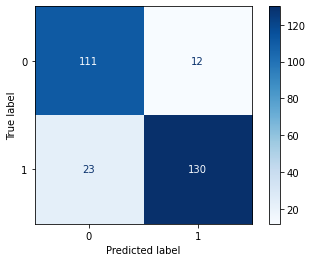

In [16]:
plot_confusion_matrix(classifier, test, test_target['HeartDisease'], cmap=plt.cm.Blues);

По сравнению с бейзлайном, качество на тестовой выборке увеличилось. Сохраним полученную модель.

## Шаг 3: Сохранение обученной модели

In [17]:
with open("model_MLPClassifier.dill", "wb") as f:
    dill.dump(classifier, f)


[CV 4/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=500, solver=lbfgs;, score=0.806 total time=   1.6s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.845 total time=   2.4s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=500, solver=sgd;, score=0.878 total time=   3.2s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=500, solver=adam;, score=0.857 total time=   4.2s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=1000, solver=lbfgs;, score=0.817 total time=   2.5s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=1000, solver=sgd;, score=0.832 total time=   2.4s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=adaptive, max_iter=1000, solver=adam;, score=0.878 total time=   6.4s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=adaptive, 

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vec

] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.824 total time=   1.5s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.789 total time=   1.2s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=constant, max_iter=500, solver=sgd;, score=0.851 total time=   2.3s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=constant, max_iter=500, solver=adam;, score=0.820 total time=   3.1s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.824 total time=   1.7s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.775 total time=   2.8s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.851 total time=   2.3s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=constant, max_i

tor y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

e=constant, max_iter=500, solver=lbfgs;, score=0.853 total time=   1.3s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=constant, max_iter=500, solver=lbfgs;, score=0.754 total time=   1.5s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=constant, max_iter=500, solver=sgd;, score=0.845 total time=   2.2s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=constant, max_iter=500, solver=sgd;, score=0.878 total time=   2.4s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=constant, max_iter=500, solver=adam;, score=0.857 total time=   3.3s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=lbfgs;, score=0.817 total time=   2.8s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=sgd;, score=0.832 total time=   2.2s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=adam;, score=0.878 total time=   5.4s
[C

  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_ite


[CV 5/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=constant, max_iter=1000, solver=adam;, score=0.855 total time=   6.0s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.845 total time=   2.2s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=constant, max_iter=1500, solver=sgd;, score=0.851 total time=   2.2s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=constant, max_iter=1500, solver=adam;, score=0.820 total time=   5.7s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=constant, max_iter=2000, solver=lbfgs;, score=0.754 total time=   1.9s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.872 total time=   2.2s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=constant, max_iter=2000, solver=sgd;, score=0.878 total time=   2.5s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=13, learning_rate=constant

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce


[CV 3/5] END alpha=1e-09, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=1500, solver=adam;, score=0.845 total time=   3.0s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=2000, solver=lbfgs;, score=0.789 total time=   3.9s
[CV 1/5] END alpha=1e-09, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.479 total time=   0.1s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.476 total time=   0.1s
[CV 3/5] END alpha=1e-09, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.509 total time=   0.1s
[CV 4/5] END alpha=1e-09, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.509 total time=   0.1s
[CV 5/5] END alpha=1e-09, hidden_layer_sizes=12, learning_rate=invscaling, max_iter=2000, solver=sgd;, score=0.491 total time=   0.1s
[CV 2/5] END alpha=1e-09, hidden_layer_sizes=12, learning_

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perce